# Implementing a Neural Network - SVM combo

In [1]:
# A bit of a setup

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st

from cs231n.classifiers.two_layer_neural_net import TwoLayerNet
from cs231n.classifiers.neural_net import ThreeLayerNet
from cs231n.data_utils import load_CIFAR10

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

## Load the data (CIFAR-10 dataset)
On the following lines of code, we will separate the into a training set, a validation set and a testing set. The training set contains 49000 images, the validation set contains 1000 images, and the testing set contain 10000 images. Then, we will do some lite preprocessing, substracting the mean image, and reshaping the data into row format (the data on original form are given on tensor format).

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=10000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the two-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
        
    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    # Reshape data to rows
    X_train = X_train.reshape(num_training, -1)
    X_val = X_val.reshape(num_validation, -1)
    X_test = X_test.reshape(num_test, -1)

    return X_train, y_train, X_val, y_val, X_test, y_test

Invoke the function and do a sanity check to see the shapes of the matrices.

In [5]:
# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

print 'Train data shape: ', X_train.shape
print 'Train labels shape: ', y_train.shape
print 'Validation data shape: ', X_val.shape
print 'Validation labels shape: ', y_val.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape

 Train data shape:  (49000, 3072)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3072)
Validation labels shape:  (1000,)
Test data shape:  (10000, 3072)
Test labels shape:  (10000,)


## Train a network

To train our network we will use different optimization algorithms (SGD, Momentum, Nesterov Momentum, Adagrad, RMSProp, Adam). In addition, we will adjust the learning rate with an exponential learning rate schedule as optimization proceeds; after each epoch, we will reduce the learning rate by multiplying it by a decay rate.

In [8]:
input_size = 32 * 32 * 3
hidden_size = 500 # number of neurons in the hidden layer
num_classes = 10
net = TwoLayerNet(input_size, hidden_size, num_classes)

# Train the network
stats = net.train(X_train, y_train, X_val, y_val,
            learning_rate=5.43e-5, learning_rate_decay=0.98,
            reg=0.3, num_iters=500, optimizer='Adam', p = 0.7,      
            batch_size=256, verbose=True, svm=False)

# Predict on the validation set
val_acc = (net.predict(X_val) == y_val).mean()
print 'Validation accuracy: ', val_acc

iteration 0 / 500: loss 510.250259
iteration 100 / 500: loss 15.231018
iteration 200 / 500: loss 7.895307
iteration 300 / 500: loss 7.348567
iteration 400 / 500: loss 8.661544
Validation accuracy:  0.348


## Debug the training

One strategy for getting insight into what's wrong is to plot the loss function and the accuracies on the training and validation sets during optimization.
Another strategy is to visualize the weights that were learned in the first layer of the network. In most neural networks trained on visual data, the first layer weights typically show some visible structure when visualized.

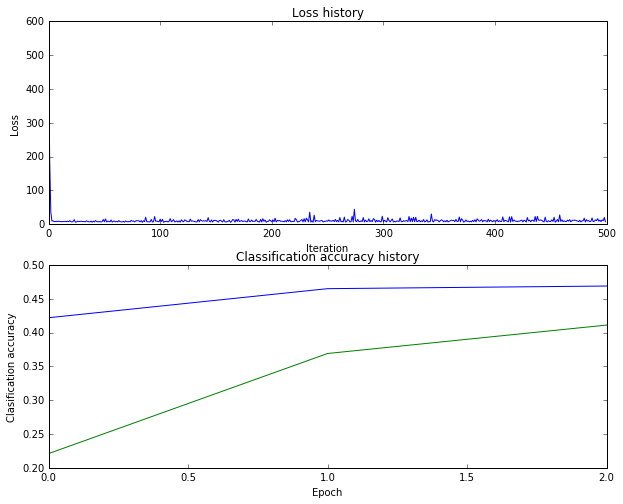

In [9]:
# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.show()

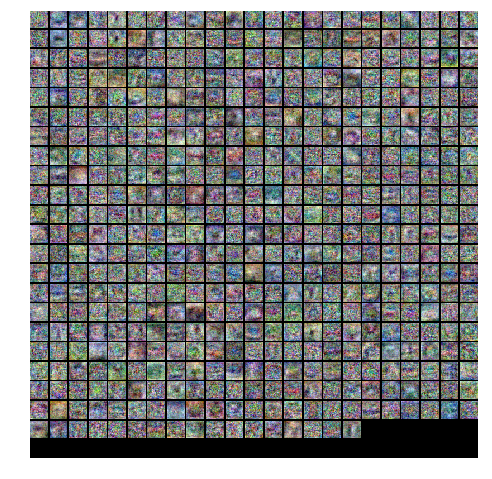

In [10]:
from cs231n.vis_utils import visualize_grid

# Visualize the weights of the network

def show_net_weights(net):
  W1 = net.params['W1']
  W1 = W1.reshape(32, 32, 3, -1).transpose(3, 0, 1, 2) 
  plt.imshow(visualize_grid(W1, padding=3).astype('uint8'))
  plt.gca().axis('off')
  plt.show()

show_net_weights(net)

## Tune your hyperparameters

In [ ]:
best_val = -1
best_net = None
best_stats = None
best_nets_ensamble = []
values_ensamble = []
best_stats_ensamble = []
results = {} 

for i in xrange(2):   
    neurons = np.random.randint(800, 1200)
    lr = np.random.uniform(3e-5, 8e-5)
    rs = np.random.uniform(0.05, 0.2)
    iters = np.random.randint(3000, 5000)
    learning_rate_decay = np.random.uniform(0.95, 1)
    p = np.random.uniform(0.4, 0.6)
    opt = np.random.choice(['Nesterov', 'Adagrad', 'RMSProp', 'Adam'])
    
    net = np.random.choice([TwoLayerNet(input_size, neurons, num_classes), ThreeLayerNet(input_size, neurons, num_classes)])

    # Train the network
    stats = net.train(X_train, y_train, X_val, y_val, lr, learning_rate_decay,
            rs, iters, opt, p, 256, False, True)

    y_train_pred = net.predict(X_train)
    acc_train = np.mean(y_train == y_train_pred)
    y_val_pred = net.predict(X_val)
    acc_val = np.mean(y_val == y_val_pred)
    
    num_layers = 0
    if type(net) == TwoLayerNet:
        num_layers = 2
    else:
        num_layers = 3
        
    optimizers = {'Nesterov': 1, 'Adagrad': 2, 'RMSProp': 3, 'Adam': 4}
    
    results[(lr, rs, neurons, learning_rate_decay, iters, num_layers, optimizers[opt], p)] = (acc_train, acc_val)
    
    accepted_accuracy = 0.5
    
    if acc_val > accepted_accuracy:
        best_nets_ensamble.append(net)
        values_ensamble.append(acc_val)
        best_stats_ensamble.append(stats)
        
    number_of_ensemblers = len(best_nets_ensamble)    

    if best_val < acc_val:
        best_stats = stats
        best_val = acc_val
        best_net = net
        
    print values_ensamble 
    print i
    
# Print out results.
for lr, reg, neurons, learning_rate_decay, iters, num_layers, opts, p  in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg, neurons, learning_rate_decay, iters, num_layers, opts, p)]
    print 'lr %e reg %e neur%e lrd %e iters %e num_layers %e opt %e p %e train accuracy: %f val accuracy: %f' % (
                lr, reg, neurons, learning_rate_decay, iters, num_layers, opts, p, train_accuracy, val_accuracy)
    
print 'best validation accuracy achieved during cross-validation: %f' % best_val 

In [23]:
test_acc = (best_net.predict(X_test) == y_test).mean()
print number_of_ensemblers

if number_of_ensemblers > 0:
    ensemble_net = np.zeros((number_of_ensemblers, len(y_test)))
    i = 0
    for net in best_nets_ensamble2:
        pred = net.predict(X_test)
        ensemble_net[i,:] = pred
        i += 1
    
    pred_final = st.mode(ensemble_net)   
    pred_final = pred_final[0]

    accuracy_ensembler = (pred_final == y_test).mean()

print 'Test accuracy - best model: ', test_acc
print 'Test accuracy - ensembler: ', accuracy_ensembler

4
Test accuracy - best model:  0.963
Test accuracy - ensembler:  0.092


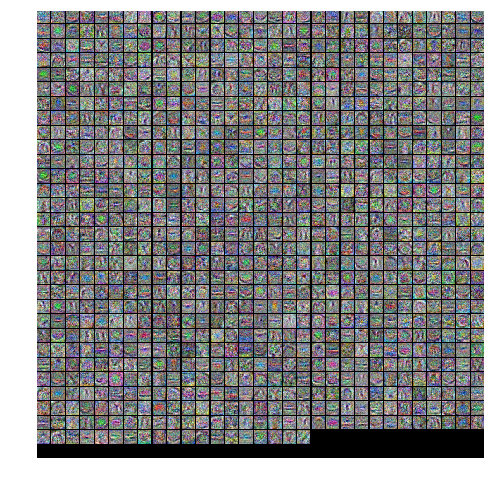

In [17]:
show_net_weights(best_net)